In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

from optimus5_utils import load_optimus5_data, load_optimus5_predictor, animate_optimus5_examples


2021-12-08 21:36:34.116703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2021-12-08 21:36:37.320142: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 21:36:37.321844: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-08 21:36:37.365358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 21:36:37.365969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
20

In [2]:
#Load Optimus-5 data and predictor

encoder = OneHotEncoder(seq_length=50, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

train_data_path = 'bottom5KIFuAUGTop5KIFuAUG.csv'
test_data_path = 'randomSampleTestingAllAUGtypes.csv'

x_train, y_train, x_test, y_test = load_optimus5_data(train_data_path, test_data_path)

predictor_path = 'saved_models/optimusRetrainedMain.hdf5'

predictor = load_optimus5_predictor(predictor_path)


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (3200, 1, 50, 4)
y_train.shape = (15008, 1)
y_test.shape = (3200, 1)


2021-12-08 21:36:39.230488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-08 21:36:39.253143: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300010000 Hz


In [3]:
#Define sequence template and background

sequence_template = '$' * 50

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)


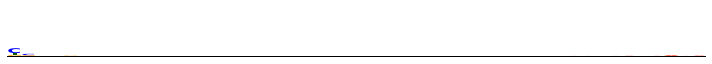

In [4]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(10, 1), logo_height=1.0, plot_start=0, plot_end=50)


In [5]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9679329305814974


In [6]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=50,
    n_out_channels=4,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='gumbel',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


In [7]:
#Train scrambler

n_epochs = 2

train_history = scrambler.train(
    predictor,
    x_train,
    y_train,
    x_test,
    y_test,
    n_epochs,
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 469 : 10},
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.125,
    entropy_weight=10.
)


/home/ubuntu/anaconda3/envs/test_gpu_2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-08 21:36:48.359093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-08 21:36:48.519831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Train on 15008 samples, validate on 3200 samples
Epoch 1/2
15008/15008 [==============================] - 79s 5ms/sample - loss: 1.2007 - nll_loss: 1.1462 - entropy_loss: 0.0545 - val_loss: 0.6261 - val_nll_loss: 0.5305 - val_entropy_loss: 0.0956
Epoch 2/2
15008/15008 [==============================] - 47s 3ms/sample - loss: 0.8788 - nll_loss: 0.8076 - entropy_loss: 0.0713 - val_loss: 0.6120 - val_nll_loss: 0.5031 - val_entropy_loss: 0.1089


In [8]:
#Save scrambler checkpoint
save_dir = 'saved_models'

model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/optimus5_inclusion_scrambler_bits_0125_epochs_10.h5 


In [9]:
#Load models
save_dir = 'saved_models'

model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/optimus5_inclusion_scrambler_bits_0125_epochs_10.h5 


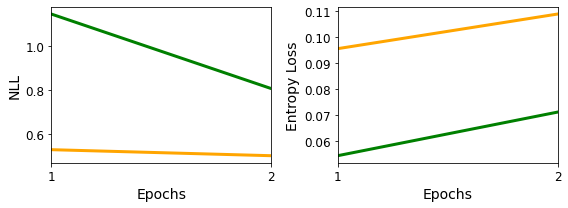

In [10]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [11]:
#Interpret the test set using the trained scrambler

pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test)


Test sequence 0:


/home/ubuntu/anaconda3/envs/test_gpu_2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 - Prediction (original) = -1.0
 - Predictions (scrambled) = [-1.5, -1.0, -1.3, -1.3, -1.2, -1.1, -1.0, -1.2, -1.6, -1.4, -1.2, -0.5, -0.8, -0.8, 0.23, -0.8, -0.7, -1.0, -1.4, -1.3, -1.0, -0.7, -0.9, -1.4, -1.1, -1.1, -0.2, -1.1, -0.9, -1.3, -1.2, -1.0]


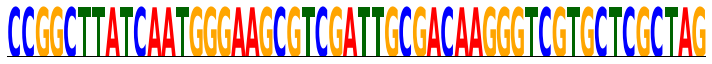

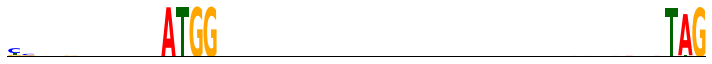

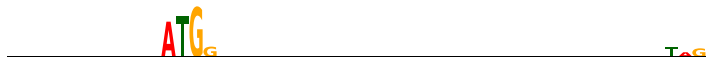

Test sequence 1:
 - Prediction (original) = -1.0
 - Predictions (scrambled) = [-0.9, -0.5, -1.3, -1.3, -0.8, -1.1, -0.9, -0.7, -1.4, -1.0, -0.7, -0.6, -1.2, -1.3, -1.0, -0.8, -0.5, -1.0, -0.8, -0.9, -1.1, -0.9, -0.9, -0.4, -0.9, -1.0, -1.2, -1.2, -1.1, -1.1, -1.4, -1.2]


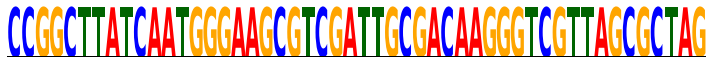

KeyboardInterrupt: 

In [12]:
#Visualize a few reconstructed sequence patterns

plot_examples = np.arange(5).tolist()
save_examples = []

importance_scores_test *= sequence_mask[None, None, :, None]

for test_ix in plot_examples :
    
    print("Test sequence " + str(test_ix) + ":")
    
    y_test_hat_ref = predictor.predict(x=[x_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    plot_dna_logo(pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
    plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test[test_ix, 0, :, :]), figsize=(10, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=50, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores")
    